# **Image Classification of Cats and Dogs**

Image processing plays a crucial role in computer vision tasks, including the classification of images into different categories such as detecting cats versus dogs. In this experiment, the goal is to develop a machine learning model that can accurately distinguish between images containing cats and images containing dogs. This experiment is fundamental in the field of computer vision and has numerous practical applications, including pet monitoring systems, animal behavior analysis, and wildlife conservation efforts.

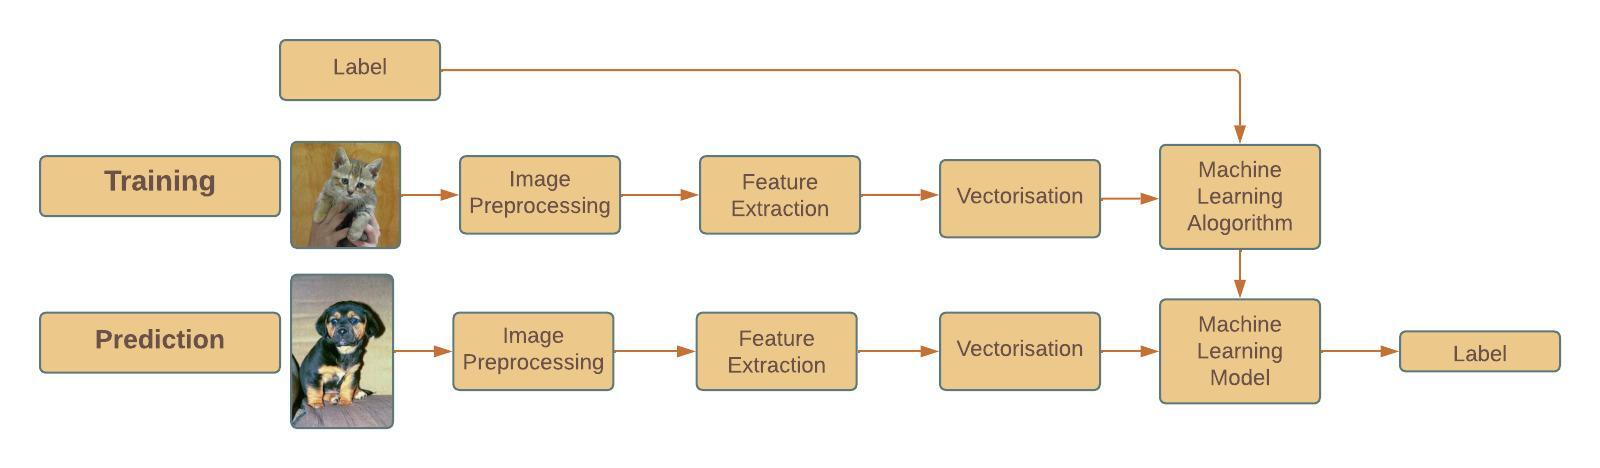

The diagram above is a flow chart which shows the major steps involved in training a model and predicting if an image is a cat or a dog.

### **Importing relevant libraries and data**

The first step taken was to import relevant python libraries. These libraries included libraries to manage the dataset, libraries for preprocessing, libraries for model evaluation,  for machine learning algorithms and other python libraries needed for this experiment.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

#libraries for preprocessing
import cv2
from sklearn.decomposition import PCA
import numpy as np
from skimage.filters import prewitt_h, prewitt_v, prewitt, sobel_h, sobel_v, sobel, laplace
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# libraries for ML algorithms
from sklearn import svm
import lightgbm as lgb

from random import randint
from random import seed
from sklearn.model_selection import train_test_split

import json
RANDOM_SEED = 100


The data was uploaded into the google drive, the google drive was mounted in this experiment and folder containing the images was unzipped in the code. This approach was used because the images were large and this was done to reduce the time spent on uploading the data when the script runtime has been disconnected and reconnected

In [2]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# unzip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/data (1).zip')

## **Data Description**

The dataset is made up of images of both cats and dogs. The data consist of 1000 samples. As seen in the bar chart below, it is shown that there is a balance in the dataset as the number of both the images of cats and the images of dogs are almost equal.

In [4]:
df_train = pd.read_csv("train.csv")

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


,id,label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


In [5]:
df_train.shape

(10000, 2)

<Axes: xlabel='label', ylabel='count'>

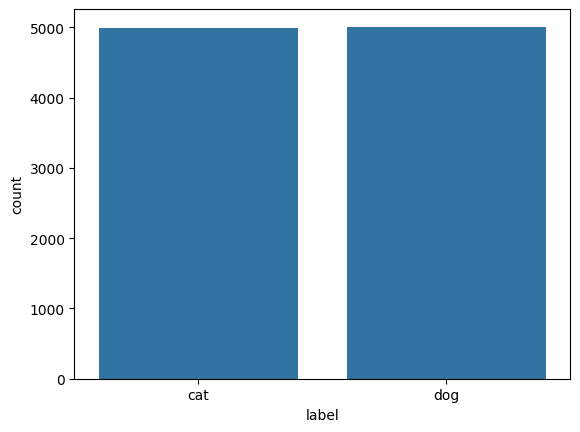

In [6]:
sns.countplot(x=df_train['label'])

In [7]:
df_test = pd.read_csv("test.csv")

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


,id
0,1
1,2
2,3
3,4
4,5


The next step carried out involved loading the images from the folder and  resizing the images to have same dimensions for all the images.

In [8]:
def load_images(ids, folder_path, dim):
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images

In [9]:
base_dim = (200, 200)

# load train images
train_image_folder = "/content/train_images"
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = '/content/test_images'
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [00:32<00:00, 303.77it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [00:02<00:00, 360.49it/s]

Number of testing images loaded: 1000


### **Data Preprocessing**

The preprocessing techniques used in this experiment were grayscaling, image resizing and histogram equalisation.

Grayscaling: Grayscaling converts a color image into a grayscale image, where each pixel is represented by a single intensity value instead of three color channels (red, green, and blue). Grayscaling simplifies the image by removing color information, making it easier to process and reducing the computational complexity of subsequent algorithms.

Image Resizing: Resizing involves changing the dimensions of an image, either by scaling it up (enlargement) or down (reduction). Resizing here was used to standardize the size of images in a dataset, ensuring consistency across samples and reducing the processing time which then increases the performance of the system (ALEnezi, 2019).

Histogram Equalisation: Histogram equalization is a technique used to enhance the contrast of an image by redistributing pixel intensities to cover the entire dynamic range more evenly. It achieves this by transforming the histogram of pixel intensities to make it more uniformly distributed (Dhal et al, 2021). Histogram equalisation was applied in this experiment to enhance the contrast of the images.

In [72]:
def get_features(images):
  features_list = []
  for img in images:
    #image grayscaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # resizing the  image
    img_resized = cv2.resize(img_grayscaled, (64, 128))
    # applying histogram equalization
    img_hist = cv2.equalizeHist(img_resized)
    #feature extraction using HOG (Histogram of Oriented Gradients)
    features, hog_image = hog(img_hist, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    features_list.append(features)
  features_list = np.array(features_list)
  return features_list

### **Feature Extraction**

Histogram of Oriented Gradients (HOG) was used in this experiment. HOG is a feature extraction technique used for object detection and image classification. It computes the distribution of gradient orientations in localized regions of an image and represents this information as a feature vector. HOG features capture the shape and texture characteristics of objects in images, making them suitable for tasks like pedestrian detection, facial recognition, and gesture recognition (Carcagnì et al, 2015). This justifies why HOG was used in this experiment.

In this experiment, HOG has shown to have the highest accuracy against edge vectors and image vectors.

In [73]:
features_train = get_features(train_images)
print(features_train.shape)

(10000, 3780)


Using label encoder in python, the categorical labels was converted to numerical data, as the experiment showed that the classification algorithm did better with numerical data.

In [74]:
Le = LabelEncoder()
df_train['label'] = Le.fit_transform(df_train['label'])
df_train.head()

,id,label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


### **Model Training and Evaluation**

The steps involved in training the data include splitting the data into train and validation set, model training and evaluation, hyperparameter tuning.

The data was splitted into training and validation set. 70% of the dataset was preserved for training due to the fact that more data is required for training the model and 30% of the data was preserved for validation.

In [75]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state = 100)

In [76]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_val.reshape(X_val.shape[0], -1)

The model was trained with different classification algorithms in this experiment and the algorithm with the highest accuracy was selected. Classification algorithms experimented which includes SVM, Random Forest Classification and Light Gradient Boosting Machine. The model using Light Gradient Boost Machine was selected as it was the model with the highest accuracy.

Light Gradient Boosting Machine is known for its speed and efficiency in training models, especially on large datasets. It utilizes a histogram-based algorithm for splitting, which reduces memory usage and speeds up computation, making it suitable for handling large-scale datasets with millions of samples (Li et al., 2024). This justifies why this model was used and why it has a high accuracy.

In [77]:
y_train = y_train.astype(np.float32)
y_test = y_val.astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

The model was created with an original accuracy of 0.723. Hyperparameter tuning was carried out to increase the accuracy to 0.749. The hyperparameters tuned includes learning rate and number of rounds. These hyperparameters is shown to have significant effect on the accuracy of the model against other hyperparameters.

In [78]:
params = { # for binary classification
    'objective': 'binary',
    'learning_rate': 0.45,
}

num_round = 235
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 3489, number of negative: 3511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.411250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963900
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 3780
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498429 -> initscore=-0.006286
[LightGBM] [Info] Start training from score -0.006286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Accuracy:               precision    recall  f1-score   support

           0       0.74      0.77      0.75      1478
           1       0.76      0.73      0.75      1522

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000
 0.7486666666666667


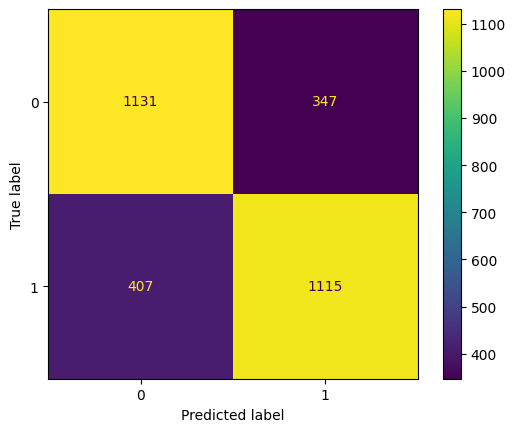

In [79]:
#predicting using the validation set using the model created
y_pred_lgb = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_lgb]

#model evaluation using classification report, accuracy and confusion matrix
accuracy = classification_report(y_val, y_pred_binary)
print(f"Accuracy: {accuracy}", accuracy_score(y_val, y_pred_binary) )

confusion_matrix = metrics.confusion_matrix(y_val, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()

### **Results and Analysis**

As shown in the table below, the experiment is shown to do best with the Light Gradient Boost Machine algorithm with an accuracy of 0.749 as against using SVM whose accuracy is 0.64 and Random Forest Classifier whose accurary is 0.71.

|Model | Classification Algorithm |Accuracy|
|------|--------------------|--------|
|M1    |SVM | 0.64 |
|M3    |Random Forest Classifier | 0.71 |
|**M4**    |**Light Gradient Boost Machine**| **0.749** |



After exploring with several preprocessing techniques, the technique sequence that has shown to perform the highest included grayscaling, resizing, histogram equalisation with Histogram of Oriented Gradients (HOG) vectors. This combination shows the highest performance.

|Model | Preprocessing | Features   | Accuracy|
|------|---------------|------------|---------|
|M1    | gray scaling   | image vector | 0.64 |
|M2    | gray scaling, resize| image vector | 0.659 |
|M3    | gray scaling, resize| edge map to vector | 0.61 |
|M4    | gray scaling, resizing, histogram equalisation | image vector | 0.64 |
|**M5**    | **gray scaling, resizing, histogram equalisation** | **HOG features** | **0.749** |

### **Conclusion**
In this image classification experiment, classification of cats and dogs were explored. Extensive preprocessing techniques were explored during the experiment which included grayscaling, resizing, histogram equalisation, and feature extraction techniques like the image vectors, edge vectors and Histogram of oriented gradiants.
Machine Learning Algorithms such as the SVM, Random Forest Classifier and the Light Gradient Boost Machine were also explored.

In this experiment, it is shown that model the with  Light Gradient Boost Machine has the highest accuracy which is 0.749. The preprocessing techniques with the highest accuracy are grayscaling, resizing, histogram equalisation and HOG feature extraction.

### **References**

ALEnezi, N.S.A., 2019. A method of skin disease detection using image processing and machine learning. Procedia Computer Science, 163, pp.85-92.

Carcagnì, P., Del Coco, M., Leo, M. and Distante, C., 2015. Facial expression recognition and histograms of oriented gradients: a comprehensive study. SpringerPlus, 4(1), pp.1-25.

Dhal, K.G., Das, A., Ray, S., Gálvez, J. and Das, S., 2021. Histogram equalization variants as optimization problems: a review. Archives of Computational Methods in Engineering, 28, pp.1471-1496.

Li, Y, Ma J., Xiao J., Wang Y., and He W., (2024) Use of extreme gradient boosting, light gradient boosting machine, and deep neural networks to evaluate the activity stage of extraocular muscles in thyroid-associated ophthalmopathy. Graefe’s archive for clinical and experimental ophthalmology. [Online] 262 (1), 203–210.

Python.org. (2020). The Python Standard Library — Python 3.8.1 documentation. [online] Available at: https://docs.python.org/3/library/.